In [1]:

import gensim
import multiprocessing
import os

In [2]:

# to reload files that are changed automatically
%load_ext autoreload
%autoreload 2

In [3]:
# import utils file - contains some useful functions
import quora_dup_utils as qu

## Parameters: file names and number of questions to use

In [17]:

# files names - if these files and folders don't exist then they are downloaded 
raw_file_name = "quora_duplicate_questions.tsv"
q1_file_name = "cleaned_q1.txt"
q2_file_name = "cleaned_q2.txt"
dup_file_name = "is_duplicate.txt"
complete_data_dataframe = "complete_data_dataframe.csv"
questions_folder_name = "cleaned_data"
google_model_path = '/Users/megoconnell/Documents/Courses/Independent Study/RNNs/GoogleNews-vectors-negative300.bin' # path to saved Google word2vec model

raw_file_name2 = "quora_duplicate_questions2.tsv"
q1_file_name2 = "2cleaned_q1.txt"
q2_file_name2 = "2cleaned_q2.txt"
dup_file_name2 = "2is_duplicate.txt"
complete_data_dataframe2 = "2complete_data_dataframe.csv"
questions_folder_name2 = "2cleaned_data"

# file to store doc2vec hyperparameters and ROC AUC errors
parameters_and_errors_name = "parameters_and_errors.csv"
parameters_and_errors_name2 = "2parameters_and_errors.csv"


# number of question pairs to use in training doc2vec
# total number of pairs is currently 404288
num_question_pairs = 404288

In [17]:
data.head(1)

,Unnamed: 0,id,qid1,qid2,question1,question2,is_duplicate,fold_id
0,0,29630,30185,30187,"b'On average, how predictable is each of the f...","b'On average, how predictable is each of the f...",1,0.0


## Download data and prepare gensim-friendly files

In [24]:
import pandas as pd
import os
import string
import requests

    # DATA CLEANING WITH PANDAS
    
    # read in file into dataframe
data = pd.read_csv('Item_Item_Diff_Paper.csv', sep='\t')

    # drop rows with null value
data.dropna(inplace=True)

train = data.loc[data['fold_id']<4.0]
test = data.loc[data['fold_id']==4.0]



In [27]:

    # make columns of lower cased words
train["cleaned_q1"] = train['question1'].str.lower()
train["cleaned_q2"] = train['question2'].str.lower()
    # remove punctuation from lower-cased words columns
train['cleaned_q1'] = train['cleaned_q1'].apply(lambda x:''.join([i for i in x if i not in string.punctuation]))
train['cleaned_q2'] = train['cleaned_q2'].apply(lambda x:''.join([i for i in x if i not in string.punctuation]))
    # remove the character "\n", which messes up the line delimiters in txt file
    # these only occur ~20 times in the questions
train["cleaned_q1"] = train['cleaned_q1'].str.replace("\n", "")
train["cleaned_q2"] = train['cleaned_q2'].str.replace("\n", "")
    # shuffle data before writing to file - this way random sample can be taken from file 
    # simply by choosing first n rows of file
train = train.sample(frac=1)

    # create directory to hold question data
if not os.path.exists(questions_folder_name):
    os.makedirs(questions_folder_name)

    # write cleaned text rows to txt files, one line for each sentence
train["cleaned_q1"].to_csv(questions_folder_name + "/" + q1_file_name, sep='\n', header=False, index=False)
train["cleaned_q2"].to_csv(questions_folder_name + "/" + q2_file_name, sep='\n', header=False, index=False)
    # write dup values to txt file, one line for each value
train["is_duplicate"].to_csv(dup_file_name, sep='\n', header=False, index=False)
    # write complete cleaning dataframe to text files as well - this can be reloaded 
    # to look at raw questions that get misclassified, etc.
train.to_csv(complete_data_dataframe, sep=',', header=True, index=False)

print ("Saved file with", len(data), "rows at", raw_file_name)

Saved file with 100424 rows at quora_duplicate_questions.tsv


In [28]:

    # make columns of lower cased words
test["cleaned_q1"] = test['question1'].str.lower()
test["cleaned_q2"] = test['question2'].str.lower()
    # remove punctuation from lower-cased words columns
test['cleaned_q1'] = test['cleaned_q1'].apply(lambda x:''.join([i for i in x if i not in string.punctuation]))
test['cleaned_q2'] = test['cleaned_q2'].apply(lambda x:''.join([i for i in x if i not in string.punctuation]))
    # remove the character "\n", which messes up the line delimiters in txt file
    # these only occur ~20 times in the questions
test["cleaned_q1"] = test['cleaned_q1'].str.replace("\n", "")
test["cleaned_q2"] = test['cleaned_q2'].str.replace("\n", "")
    # shuffle data before writing to file - this way random sample can be taken from file 
    # simply by choosing first n rows of file
test = test.sample(frac=1)

    # create directory to hold question data
if not os.path.exists(questions_folder_name2):
    os.makedirs(questions_folder_name2)

    # write cleaned text rows to txt files, one line for each sentence
test["cleaned_q1"].to_csv(questions_folder_name2 + "/" + q1_file_name2, sep='\n', header=False, index=False)
test["cleaned_q2"].to_csv(questions_folder_name2 + "/" + q2_file_name2, sep='\n', header=False, index=False)
    # write dup values to txt file, one line for each value
test["is_duplicate"].to_csv(dup_file_name2, sep='\n', header=False, index=False)
    # write complete cleaning dataframe to text files as well - this can be reloaded 
    # to look at raw questions that get misclassified, etc.
test.to_csv(complete_data_dataframe2, sep=',', header=True, index=False)

print ("Saved file with", len(data), "rows at", raw_file_name2)

Saved file with 100424 rows at quora_duplicate_questions2.tsv


In [29]:
from itertools import count

# class that iterates through first "rows" lines of questions list ("rows" is integer)
class LabeledLineSentence(object):
    def __init__(self, dirname, rows=None):
        self.dirname = dirname
        self.rows = rows
    def __iter__(self):
        for filename in os.listdir(self.dirname):
            for uid, text_line in enumerate(open(os.path.join(self.dirname, filename))):
                if self.rows:
                    if uid >= self.rows: 
                        break
            # for uid, line in enumerate(open(os.path.join(self.dirname, filename))):
                yield gensim.models.doc2vec.LabeledSentence(words=text_line.split(), tags=[os.path.basename(filename) + '_%s' % uid])

# make sure using fast version
assert gensim.models.doc2vec.FAST_VERSION > -1
cores = multiprocessing.cpu_count() # number of cores on computer to use for computations

In [30]:

# load data into memory - all data combined should only be 200-300 megabytes
# this is done instead of using iterator - makes doing shuffles of data easier

all_docs = []
sentences = LabeledLineSentence(questions_folder_name, rows=num_question_pairs)
for sentence in sentences:
    all_docs.append(sentence)

print('%d question pairs to train (%d documents total)' % (num_question_pairs, len(all_docs)))

/Users/megoconnell/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  from ipykernel import kernelapp as app


404288 question pairs to train (160680 documents total)


In [32]:

# load data into memory - all data combined should only be 200-300 megabytes
# this is done instead of using iterator - makes doing shuffles of data easier

all_docs2 = []
sentences2 = LabeledLineSentence(questions_folder_name2, rows=num_question_pairs)
for sentence in sentences2:
    all_docs2.append(sentence)

print('%d question pairs to train (%d documents total)' % (num_question_pairs, len(all_docs)))

/Users/megoconnell/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  from ipykernel import kernelapp as app


404288 question pairs to train (160680 documents total)


In [33]:
# make list of tuples (document1, document2, is_dup) for all num_question_pairs
# the document names come from naming scheme used in LabeledLineSentence class 

questions_file_names = [os.path.basename(filename) for filename in os.listdir(questions_folder_name)]
doc_names_and_duplicate_class = []
for i, line in enumerate(open(dup_file_name)):
    if i >= num_question_pairs:
        break
    doc_tup = (questions_file_names[0] + "_" + str(i), questions_file_names[1] + "_" + str(i), int(line.strip("\n")))
    doc_names_and_duplicate_class.append(doc_tup)

print (len(doc_names_and_duplicate_class), "document pairs to classify")
print ("Document pair names and labels contained in doc_names_and_duplicate_class")

80340 document pairs to classify
Document pair names and labels contained in doc_names_and_duplicate_class


In [36]:
# make list of tuples (document1, document2, is_dup) for all num_question_pairs
# the document names come from naming scheme used in LabeledLineSentence class 

questions_file_names2 = [os.path.basename(filename) for filename in os.listdir(questions_folder_name2)]
doc_names_and_duplicate_class2 = []
for i, line in enumerate(open(dup_file_name2)):
    if i >= num_question_pairs:
        break
    doc_tup = (questions_file_names2[0] + "_" + str(i), questions_file_names2[1] + "_" + str(i), int(line.strip("\n")))
    doc_names_and_duplicate_class2.append(doc_tup)

print (len(doc_names_and_duplicate_class2), "document pairs to classify")
print ("Document pair names and labels contained in doc_names_and_duplicate_class2")

20084 document pairs to classify
Document pair names and labels contained in doc_names_and_duplicate_class2


In [37]:
# produce logs during training
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
rootLogger = logging.getLogger()
rootLogger.setLevel(logging.INFO)

In [38]:

# set model parameters parameters

parameters_dict = {

'documents' : all_docs,
'dm' : 0, # use bag-of-words (dbow) model; 1 uses embedding (dmpv) model
'size' : 200, # size of word/doc vectors
'window' : 15, # # max distance between word and neighbor word for word embeddings
'alpha' : .025, # learning rate - use rate in paper
'min_alpha' : 0.0001, # rate from paper
'min_count' : 5, # ignore words with count less than this
'sample' : 1e-5, # how to configure downsampling for high frequency words
'workers' : cores, # number of cores to use
'hs' : 0, # use negative sampling
'negative' : 5, # used in negative sampling
'dbow_words' : 1, # trains word vectors in addition to document vectors in dbow model
'iter' : 3 # recommended number of epochs is ~20 for dbow model on question comparison   

}

In [40]:
# create list of parameters to use in model
from itertools import product

dms = [0]
sizes = [300]
windows = [5]
alphas = [0.025]
min_alphas = [0.0001]
min_counts = [1, 5]
samples = [1e-5]
workers_s = [cores]
hs_s = [0]
negatives = [5]
dbow_words_s = [1]
iters = [25]

# create iterable of all combinations of parameters
params_product = product(dms, sizes, windows, alphas, min_alphas, 
                        min_counts, samples, workers_s, hs_s, negatives, 
                        dbow_words_s, iters)
parameters = [x for x in params_product]

In [43]:
# create list to score ROC AUC scores and their model parameters
params_and_errors = []

print ("Starting first run of", len(parameters), "runs")
total_time = 0
for run_number, pars in enumerate(parameters): 
    params = {'dm':pars[0], 'size':pars[1], 'window':pars[2], 
              'alpha':pars[3], 'min_alpha':pars[4], 'min_count':pars[5],
              'sample':pars[6], 'workers':pars[7], 'hs':pars[8],
              'negative':pars[9], 'dbow_words':pars[10], 'iter':pars[11]}
    with qu.elapsed_timer() as elapsed:
        model = gensim.models.doc2vec.Doc2Vec(documents=all_docs, **params)
        AUC_value = qu.calculate_AUC(model, doc_names_and_duplicate_class)
        duration = '%.1f' % elapsed()
        # save time to complete computation
        m, s = divmod(float(duration), 60)
        h, m = divmod(m, 60)
        time_string = "%dh %02dm %02ds" % (h, m, s)
        params_and_errors.append((params, AUC_value, time_string))
        total_time += float(duration)
        print ()
        print ("Completed run number", run_number + 1, "of", len(parameters), "runs total")
        print ("AUC score:", round(AUC_value, 4))
        print ("Training for this run took", round(float(duration)/60.,1), "minutes")

best_AUC = max([x[1] for x in params_and_errors])
print()
print()
print ("Total training time for all runs:", round(float(total_time)/3600.,2), "hours")
print ("Best AUC value:", round(best_AUC, 6))
print ("Paramters for best AUC value:", [x[0] for x in params_and_errors if x[1] == best_AUC][0]
)
# convert params and errors into easy-to-read pandas dataframe
params_df = pd.DataFrame([x[0] for x in params_and_errors])
params_df["AUC"] = pd.Series([x[1] for x in params_and_errors])
params_df["num_doc_pairs"] = pd.Series([len(all_docs) for _ in range(len(params_and_errors))])
params_df["compute_time"] = pd.Series([x[2] for x in params_and_errors])
params_df.sort_values("AUC", ascending=False, inplace=True)

# write parameter values to csv - append if this csv already exists
header=True
if os.path.isfile(parameters_and_errors_name):
    header=False
params_df.to_csv(parameters_and_errors_name, header=header, index=False, mode="a")

/Users/megoconnell/anaconda/lib/python3.5/site-packages/gensim/models/doc2vec.py:362: UserWarning: The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.
  warnings.warn("The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.")
/Users/megoconnell/anaconda/lib/python3.5/site-packages/gensim/models/doc2vec.py:366: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
2018-04-16 22:14:25,877 : INFO : collecting all words and their counts
2018-04-16 22:14:25,878 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2018-04-16 22:14:25,977 : INFO : PROGRESS: at example #10000, processed 138247 words (1403641/s), 5994 word types, 10000 tags


Starting first run of 2 runs


2018-04-16 22:14:26,077 : INFO : PROGRESS: at example #20000, processed 274419 words (1378975/s), 7051 word types, 20000 tags
2018-04-16 22:14:26,189 : INFO : PROGRESS: at example #30000, processed 411567 words (1242516/s), 7634 word types, 30000 tags
2018-04-16 22:14:26,289 : INFO : PROGRESS: at example #40000, processed 549845 words (1383608/s), 7918 word types, 40000 tags
2018-04-16 22:14:26,389 : INFO : PROGRESS: at example #50000, processed 686582 words (1385579/s), 8085 word types, 50000 tags
2018-04-16 22:14:26,476 : INFO : PROGRESS: at example #60000, processed 824684 words (1602945/s), 8190 word types, 60000 tags
2018-04-16 22:14:26,612 : INFO : PROGRESS: at example #70000, processed 961911 words (1018083/s), 8283 word types, 70000 tags
2018-04-16 22:14:26,766 : INFO : PROGRESS: at example #80000, processed 1098018 words (892439/s), 8342 word types, 80000 tags
2018-04-16 22:14:27,282 : INFO : PROGRESS: at example #90000, processed 1234905 words (265933/s), 8404 word types, 900

2018-04-16 22:15:05,158 : INFO : EPOCH 5 - PROGRESS: at 42.53% examples, 79996 words/s, in_qsize 7, out_qsize 0
2018-04-16 22:15:06,203 : INFO : EPOCH 5 - PROGRESS: at 57.12% examples, 79634 words/s, in_qsize 7, out_qsize 0
2018-04-16 22:15:07,230 : INFO : EPOCH 5 - PROGRESS: at 72.33% examples, 80134 words/s, in_qsize 7, out_qsize 0
2018-04-16 22:15:08,257 : INFO : EPOCH 5 - PROGRESS: at 87.82% examples, 80824 words/s, in_qsize 7, out_qsize 0
2018-04-16 22:15:08,999 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-04-16 22:15:09,025 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-04-16 22:15:09,030 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-04-16 22:15:09,047 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-04-16 22:15:09,048 : INFO : EPOCH - 5 : training on 2193663 raw words (564549 effective words) took 6.9s, 81379 effective words/s
2018-04-16 22:15:10,059 : INFO : EPOCH 6 - PROGRESS: 

2018-04-16 22:15:53,567 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-04-16 22:15:53,567 : INFO : EPOCH - 11 : training on 2193663 raw words (563563 effective words) took 6.8s, 82473 effective words/s
2018-04-16 22:15:54,589 : INFO : EPOCH 12 - PROGRESS: at 13.15% examples, 74051 words/s, in_qsize 8, out_qsize 0
2018-04-16 22:15:55,599 : INFO : EPOCH 12 - PROGRESS: at 28.53% examples, 80719 words/s, in_qsize 7, out_qsize 0
2018-04-16 22:15:56,608 : INFO : EPOCH 12 - PROGRESS: at 43.44% examples, 81976 words/s, in_qsize 7, out_qsize 0
2018-04-16 22:15:57,624 : INFO : EPOCH 12 - PROGRESS: at 58.50% examples, 82372 words/s, in_qsize 7, out_qsize 0
2018-04-16 22:15:58,666 : INFO : EPOCH 12 - PROGRESS: at 74.14% examples, 82484 words/s, in_qsize 7, out_qsize 0
2018-04-16 22:15:59,679 : INFO : EPOCH 12 - PROGRESS: at 88.74% examples, 82123 words/s, in_qsize 7, out_qsize 0
2018-04-16 22:16:00,335 : INFO : worker thread finished; awaiting finish of 3 more threads
2018

2018-04-16 22:16:42,669 : INFO : EPOCH 18 - PROGRESS: at 48.03% examples, 67444 words/s, in_qsize 7, out_qsize 0
2018-04-16 22:16:43,743 : INFO : EPOCH 18 - PROGRESS: at 59.44% examples, 65741 words/s, in_qsize 7, out_qsize 0
2018-04-16 22:16:44,780 : INFO : EPOCH 18 - PROGRESS: at 71.42% examples, 65413 words/s, in_qsize 8, out_qsize 0
2018-04-16 22:16:45,787 : INFO : EPOCH 18 - PROGRESS: at 82.33% examples, 64760 words/s, in_qsize 8, out_qsize 0
2018-04-16 22:16:46,839 : INFO : EPOCH 18 - PROGRESS: at 92.82% examples, 63575 words/s, in_qsize 7, out_qsize 0
2018-04-16 22:16:47,365 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-04-16 22:16:47,379 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-04-16 22:16:47,395 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-04-16 22:16:47,401 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-04-16 22:16:47,402 : INFO : EPOCH - 18 : training on 2193663 raw w

2018-04-16 22:17:33,337 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-04-16 22:17:33,355 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-04-16 22:17:33,381 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-04-16 22:17:33,383 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-04-16 22:17:33,384 : INFO : EPOCH - 24 : training on 2193663 raw words (563601 effective words) took 7.7s, 73046 effective words/s
2018-04-16 22:17:34,407 : INFO : EPOCH 25 - PROGRESS: at 13.61% examples, 77356 words/s, in_qsize 8, out_qsize 0
2018-04-16 22:17:35,424 : INFO : EPOCH 25 - PROGRESS: at 29.44% examples, 83371 words/s, in_qsize 7, out_qsize 0
2018-04-16 22:17:36,453 : INFO : EPOCH 25 - PROGRESS: at 44.36% examples, 83274 words/s, in_qsize 7, out_qsize 0
2018-04-16 22:17:37,470 : INFO : EPOCH 25 - PROGRESS: at 59.89% examples, 83912 words/s, in_qsize 7, out_qsize 0
2018-04-16 22:17:38,511 : INFO : EPOCH 25 - PROG


Completed run number 1 of 2 runs total
AUC score: 0.9284
Training for this run took 3.3 minutes


2018-04-16 22:17:42,395 : INFO : PROGRESS: at example #30000, processed 411567 words (1441656/s), 7634 word types, 30000 tags
2018-04-16 22:17:42,514 : INFO : PROGRESS: at example #40000, processed 549845 words (1170815/s), 7918 word types, 40000 tags
2018-04-16 22:17:42,642 : INFO : PROGRESS: at example #50000, processed 686582 words (1091546/s), 8085 word types, 50000 tags
2018-04-16 22:17:42,752 : INFO : PROGRESS: at example #60000, processed 824684 words (1260255/s), 8190 word types, 60000 tags
2018-04-16 22:17:42,846 : INFO : PROGRESS: at example #70000, processed 961911 words (1487371/s), 8283 word types, 70000 tags
2018-04-16 22:17:42,929 : INFO : PROGRESS: at example #80000, processed 1098018 words (1650884/s), 8342 word types, 80000 tags
2018-04-16 22:17:43,017 : INFO : PROGRESS: at example #90000, processed 1234905 words (1580886/s), 8404 word types, 90000 tags
2018-04-16 22:17:43,118 : INFO : PROGRESS: at example #100000, processed 1369538 words (1354772/s), 8439 word types,

2018-04-16 22:18:22,118 : INFO : EPOCH 5 - PROGRESS: at 28.53% examples, 79400 words/s, in_qsize 7, out_qsize 0
2018-04-16 22:18:23,126 : INFO : EPOCH 5 - PROGRESS: at 42.53% examples, 79298 words/s, in_qsize 7, out_qsize 0
2018-04-16 22:18:24,134 : INFO : EPOCH 5 - PROGRESS: at 58.05% examples, 81048 words/s, in_qsize 8, out_qsize 0
2018-04-16 22:18:25,192 : INFO : EPOCH 5 - PROGRESS: at 73.25% examples, 80675 words/s, in_qsize 7, out_qsize 0
2018-04-16 22:18:26,194 : INFO : EPOCH 5 - PROGRESS: at 88.28% examples, 81180 words/s, in_qsize 7, out_qsize 0
2018-04-16 22:18:26,906 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-04-16 22:18:26,930 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-04-16 22:18:26,937 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-04-16 22:18:26,950 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-04-16 22:18:26,950 : INFO : EPOCH - 5 : training on 2193663 raw words (

2018-04-16 22:19:14,869 : INFO : EPOCH 11 - PROGRESS: at 59.44% examples, 66095 words/s, in_qsize 7, out_qsize 0
2018-04-16 22:19:15,943 : INFO : EPOCH 11 - PROGRESS: at 70.96% examples, 64907 words/s, in_qsize 7, out_qsize 0
2018-04-16 22:19:16,944 : INFO : EPOCH 11 - PROGRESS: at 84.63% examples, 66441 words/s, in_qsize 7, out_qsize 0
2018-04-16 22:19:17,952 : INFO : EPOCH 11 - PROGRESS: at 96.53% examples, 66334 words/s, in_qsize 8, out_qsize 0
2018-04-16 22:19:18,126 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-04-16 22:19:18,141 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-04-16 22:19:18,156 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-04-16 22:19:18,161 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-04-16 22:19:18,162 : INFO : EPOCH - 11 : training on 2193663 raw words (562046 effective words) took 8.4s, 66981 effective words/s
2018-04-16 22:19:19,232 : INFO : EPOCH 12 - PROG

2018-04-16 22:20:04,353 : INFO : EPOCH 17 - PROGRESS: at 67.75% examples, 74064 words/s, in_qsize 7, out_qsize 0
2018-04-16 22:20:05,363 : INFO : EPOCH 17 - PROGRESS: at 80.53% examples, 73422 words/s, in_qsize 7, out_qsize 0
2018-04-16 22:20:06,369 : INFO : EPOCH 17 - PROGRESS: at 94.19% examples, 73725 words/s, in_qsize 7, out_qsize 0
2018-04-16 22:20:06,804 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-04-16 22:20:06,821 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-04-16 22:20:06,832 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-04-16 22:20:06,839 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-04-16 22:20:06,840 : INFO : EPOCH - 17 : training on 2193663 raw words (561650 effective words) took 7.6s, 73423 effective words/s
2018-04-16 22:20:07,855 : INFO : EPOCH 18 - PROGRESS: at 12.23% examples, 69702 words/s, in_qsize 7, out_qsize 0
2018-04-16 22:20:08,873 : INFO : EPOCH 18 - PROG

2018-04-16 22:20:53,283 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-04-16 22:20:53,310 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-04-16 22:20:53,337 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-04-16 22:20:53,345 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-04-16 22:20:53,346 : INFO : EPOCH - 23 : training on 2193663 raw words (562230 effective words) took 8.7s, 64599 effective words/s
2018-04-16 22:20:54,369 : INFO : EPOCH 24 - PROGRESS: at 10.84% examples, 60607 words/s, in_qsize 7, out_qsize 0
2018-04-16 22:20:55,371 : INFO : EPOCH 24 - PROGRESS: at 23.99% examples, 67458 words/s, in_qsize 7, out_qsize 0
2018-04-16 22:20:56,393 : INFO : EPOCH 24 - PROGRESS: at 34.39% examples, 64273 words/s, in_qsize 7, out_qsize 0
2018-04-16 22:20:57,412 : INFO : EPOCH 24 - PROGRESS: at 44.36% examples, 62115 words/s, in_qsize 7, out_qsize 0
2018-04-16 22:20:58,439 : INFO : EPOCH 24 - PROG


Completed run number 2 of 2 runs total
AUC score: 0.9279
Training for this run took 3.5 minutes


Total training time for all runs: 0.11 hours
Best AUC value: 0.928385
Paramters for best AUC value: {'min_alpha': 0.0001, 'iter': 25, 'sample': 1e-05, 'size': 300, 'negative': 5, 'alpha': 0.025, 'window': 5, 'min_count': 1, 'dm': 0, 'workers': 4, 'hs': 0, 'dbow_words': 1}


In [45]:
params_df

,alpha,dbow_words,dm,hs,iter,min_alpha,min_count,negative,sample,size,window,workers,AUC,num_doc_pairs,compute_time
0,0.025,1,0,0,25,0.0001,1,5,0.00001,300,5,4,0.928385,160680,0h 03m 16s
1,0.025,1,0,0,25,0.0001,5,5,0.00001,300,5,4,0.927865,160680,0h 03m 29s


In [46]:
params_df.loc[:, (params_df != params_df.ix[0]).any()]

/Users/megoconnell/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


,min_count,AUC,compute_time
0,1,0.928385,0h 03m 16s
1,5,0.927865,0h 03m 29s


In [47]:
# read in paramater file to see what has been done before
all_params_df = pd.read_csv(parameters_and_errors_name)
all_params_df.sort_values("AUC", ascending=False, inplace=True)
# drop duplicate rows (not including AUC scores, which might vary slightly due to randomness)
dup_columns = [u'alpha', u'dbow_words', u'dm', u'hs', u'iter', u'min_alpha',
       u'min_count', u'negative', u'sample', u'size', u'window', u'workers',
       u'num_doc_pairs']
all_params_df.drop_duplicates(subset=dup_columns,inplace=True)

In [48]:
all_params_df

,alpha,dbow_words,dm,hs,iter,min_alpha,min_count,negative,sample,size,window,workers,AUC,num_doc_pairs,compute_time
2,0.025,1,0,0,25,0.0001,1,5,0.00001,300,5,4,0.934298,200848,0h 03m 54s
3,0.025,1,0,0,25,0.0001,5,5,0.00001,300,5,4,0.933632,200848,0h 04m 21s
6,0.025,1,0,0,25,0.0001,1,5,0.00001,300,5,4,0.928385,160680,0h 03m 16s
7,0.025,1,0,0,25,0.0001,5,5,0.00001,300,5,4,0.927865,160680,0h 03m 29s


In [50]:
all_docsT = (all_docs, all_docs2)

In [56]:
best_params = {'dm':0, 'size':300, 'window':5, 
              'alpha':.025, 'min_alpha':.0001, 'min_count':1,
              'sample':5e-5, 'workers':cores, 'hs':0,
              'negative':5, 'dbow_words':1, 'iter':25}
with qu.elapsed_timer() as elapsed:
    model = gensim.models.doc2vec.Doc2Vec(documents=all_docs, **best_params)
    AUC_value = qu.calculate_AUC(model, doc_names_and_duplicate_class)
    duration = '%.1f' % elapsed()
    print ("AUC score:", round(AUC_value, 4))
    print ("Training for this run took", round(float(duration)/60.,1), "minutes")

/Users/megoconnell/anaconda/lib/python3.5/site-packages/gensim/models/doc2vec.py:362: UserWarning: The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.
  warnings.warn("The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.")
/Users/megoconnell/anaconda/lib/python3.5/site-packages/gensim/models/doc2vec.py:366: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
2018-04-16 22:31:46,551 : INFO : collecting all words and their counts
2018-04-16 22:31:46,552 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2018-04-16 22:31:46,662 : INFO : PROGRESS: at example #10000, processed 138247 words (1260203/s), 5994 word types, 10000 tags
2018-04-16 22:31:46,772 : INFO : PROGRESS: at example #20000, processed 274419 words (1250777/s), 7051 word types, 20

2018-04-16 22:32:21,464 : INFO : EPOCH 4 - PROGRESS: at 10.38% examples, 94661 words/s, in_qsize 7, out_qsize 0
2018-04-16 22:32:22,467 : INFO : EPOCH 4 - PROGRESS: at 20.84% examples, 96168 words/s, in_qsize 7, out_qsize 0
2018-04-16 22:32:23,524 : INFO : EPOCH 4 - PROGRESS: at 31.25% examples, 95087 words/s, in_qsize 8, out_qsize 0
2018-04-16 22:32:24,531 : INFO : EPOCH 4 - PROGRESS: at 42.98% examples, 98733 words/s, in_qsize 8, out_qsize 0
2018-04-16 22:32:25,533 : INFO : EPOCH 4 - PROGRESS: at 53.92% examples, 99294 words/s, in_qsize 7, out_qsize 0
2018-04-16 22:32:26,536 : INFO : EPOCH 4 - PROGRESS: at 64.53% examples, 98832 words/s, in_qsize 7, out_qsize 0
2018-04-16 22:32:27,559 : INFO : EPOCH 4 - PROGRESS: at 74.14% examples, 97029 words/s, in_qsize 8, out_qsize 0
2018-04-16 22:32:28,603 : INFO : EPOCH 4 - PROGRESS: at 86.89% examples, 99020 words/s, in_qsize 7, out_qsize 0
2018-04-16 22:32:29,530 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-04-16 22

2018-04-16 22:33:16,104 : INFO : EPOCH 9 - PROGRESS: at 89.19% examples, 97036 words/s, in_qsize 7, out_qsize 0
2018-04-16 22:33:16,883 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-04-16 22:33:16,901 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-04-16 22:33:16,913 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-04-16 22:33:16,924 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-04-16 22:33:16,925 : INFO : EPOCH - 9 : training on 2193663 raw words (930025 effective words) took 9.4s, 99144 effective words/s
2018-04-16 22:33:17,949 : INFO : EPOCH 10 - PROGRESS: at 11.31% examples, 104736 words/s, in_qsize 7, out_qsize 0
2018-04-16 22:33:18,964 : INFO : EPOCH 10 - PROGRESS: at 24.43% examples, 113358 words/s, in_qsize 7, out_qsize 0
2018-04-16 22:33:20,055 : INFO : EPOCH 10 - PROGRESS: at 36.21% examples, 109402 words/s, in_qsize 7, out_qsize 0
2018-04-16 22:33:21,126 : INFO : EPOCH 10 - PRO

2018-04-16 22:34:08,554 : INFO : EPOCH 15 - PROGRESS: at 64.06% examples, 95337 words/s, in_qsize 7, out_qsize 0
2018-04-16 22:34:09,560 : INFO : EPOCH 15 - PROGRESS: at 73.70% examples, 94262 words/s, in_qsize 7, out_qsize 0
2018-04-16 22:34:10,570 : INFO : EPOCH 15 - PROGRESS: at 83.26% examples, 93422 words/s, in_qsize 7, out_qsize 0
2018-04-16 22:34:11,624 : INFO : EPOCH 15 - PROGRESS: at 92.81% examples, 92330 words/s, in_qsize 7, out_qsize 0
2018-04-16 22:34:12,180 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-04-16 22:34:12,191 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-04-16 22:34:12,194 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-04-16 22:34:12,197 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-04-16 22:34:12,198 : INFO : EPOCH - 15 : training on 2193663 raw words (930780 effective words) took 9.9s, 93619 effective words/s
2018-04-16 22:34:13,299 : INFO : EPOCH 16 - PROG

2018-04-16 22:35:01,016 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-04-16 22:35:01,032 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-04-16 22:35:01,040 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-04-16 22:35:01,041 : INFO : EPOCH - 20 : training on 2193663 raw words (929622 effective words) took 9.4s, 98579 effective words/s
2018-04-16 22:35:02,067 : INFO : EPOCH 21 - PROGRESS: at 9.94% examples, 92541 words/s, in_qsize 7, out_qsize 0
2018-04-16 22:35:03,105 : INFO : EPOCH 21 - PROGRESS: at 20.84% examples, 95705 words/s, in_qsize 7, out_qsize 0
2018-04-16 22:35:04,168 : INFO : EPOCH 21 - PROGRESS: at 32.60% examples, 98753 words/s, in_qsize 7, out_qsize 0
2018-04-16 22:35:05,186 : INFO : EPOCH 21 - PROGRESS: at 43.44% examples, 99220 words/s, in_qsize 7, out_qsize 0
2018-04-16 22:35:06,191 : INFO : EPOCH 21 - PROGRESS: at 54.83% examples, 100550 words/s, in_qsize 7, out_qsize 0
2018-04-16 22:35:07,202 : 

AUC score: 0.9552
Training for this run took 4.1 minutes


In [ ]:
best_params2 = {'dm':0, 'size':300, 'window':5, 
              'alpha':.025, 'min_alpha':.0001, 'min_count':1,
              'sample':5e-5, 'workers':cores, 'hs':0,
              'negative':5, 'dbow_words':1, 'iter':25}
with qu.elapsed_timer() as elapsed:
    model2 = gensim.models.doc2vec.Doc2Vec(documents=all_docs2, **best_params2)
    AUC_value2 = qu.calculate_AUC(model2, doc_names_and_duplicate_class2)
    duration2 = '%.1f' % elapsed()
    print ("AUC score2:", round(AUC_value, 4))
    print ("Training for this run2 took", round(float(duration2)/60.,1), "minutes")

In [ ]:

y_target, y_pred = qu.get_model_distances_and_scores(model, doc_names_and_duplicate_class)
qu.report_accuracy_prec_recall_F1(y_target, y_pred)

In [ ]:

y_target2, y_pred2 = qu.get_model_distances_and_scores(model2, doc_names_and_duplicate_class2)
qu.report_accuracy_prec_recall_F1(y_target2, y_pred2)

In [ ]:
best_params = {'dm':0, 'size':300, 'window':5, 
              'alpha':.025, 'min_alpha':.0001, 'min_count':1,
              'sample':5e-5, 'workers':cores, 'hs':0,
              'negative':5, 'dbow_words':1, 'iter':25}
with qu.elapsed_timer() as elapsed:
    model = gensim.models.doc2vec.Doc2Vec(documents=all_docs, **best_params)
    AUC_value = qu.calculate_AUC(model, doc_names_and_duplicate_class)
    duration = '%.1f' % elapsed()
    print( "AUC score:", round(AUC_value, 4))
    print ("Training for this run took", round(float(duration)/60.,1), "minutes")

In [ ]:
best_params2 = {'dm':0, 'size':300, 'window':5, 
              'alpha':.025, 'min_alpha':.0001, 'min_count':1,
              'sample':5e-5, 'workers':cores, 'hs':0,
              'negative':5, 'dbow_words':1, 'iter':25}
with qu.elapsed_timer() as elapsed:
    model2 = gensim.models.doc2vec.Doc2Vec(documents=all_docs2, **best_params2)
    AUC_value = qu.calculate_AUC(model2, doc_names_and_duplicate_class2)
    duration2 = '%.1f' % elapsed()
    print( "AUC score2:", round(AUC_value, 4))
    print ("Training for this run2 took", round(float(duration2)/60.,1), "minutes")

In [26]:
# in case you want to keep question vectors stored in dataframe containing 
# all the original data, can load in data currently being used and add document vectors to it if desired
current_data1 = pd.read_csv(complete_data_dataframe, nrows=num_question_pairs)
current_data2 = pd.read_csv(complete_data_dataframe2, nrows=num_question_pairs)


In [28]:

# add numpy doc2vec representation for each question (2 questions per row)
# the documents in doc_names_and_duplicate_class are in same order as documents in current_data dataframe
# (and current_data is read from complete_data_dataframe csv file)
q1_vecs = []
q2_vecs = []
is_dup = []

for i in range(len(doc_names_and_duplicate_class)):
    # get word vectors for each question and add to current_data dataframe
    vec1_name = doc_names_and_duplicate_class[i][0]
    vec2_name = doc_names_and_duplicate_class[i][1]
    vec1 = model.docvecs[vec1_name]         
    vec2 = model.docvecs[vec2_name] 
    q1_vecs.append(vec1)
    q2_vecs.append(vec2)
    is_dup.append(doc_names_and_duplicate_class[i][2])

# sanity check that ensures document vectors match their text in dataframe - compare the duplicate 
# tags between current_data and doc_names_and_duplicate_class

for i in range(len(doc_names_and_duplicate_class)):
    assert doc_names_and_duplicate_class[i][2] == current_data["is_duplicate"][i], "Error in aligning document \
                                                                              vectors with their text at index %d" % i

current_data1["q1_vecs"] = pd.Series(q1_vecs)
current_data1["q2_vecs"] = pd.Series(q2_vecs)
print ("Document vectors added to current_data dataframe")

Document vectors added to current_data dataframe


In [ ]:

# add numpy doc2vec representation for each question (2 questions per row)
# the documents in doc_names_and_duplicate_class are in same order as documents in current_data dataframe
# (and current_data is read from complete_data_dataframe csv file)
q1_vecs2 = []
q2_vecs2 = []
is_dup2 = []

for i in range(len(doc_names_and_duplicate_class2)):
    # get word vectors for each question and add to current_data dataframe
    vec1_name2 = doc_names_and_duplicate_class2[i][0]
    vec2_name2 = doc_names_and_duplicate_class2[i][1]
    vec1 = model.docvecs[vec1_name2]         
    vec2 = model.docvecs[vec2_name2] 
    q1_vecs2.append(vec1)
    q2_vecs2.append(vec2)
    is_dup2.append(doc_names_and_duplicate_class2[i][2])

# sanity check that ensures document vectors match their text in dataframe - compare the duplicate 
# tags between current_data and doc_names_and_duplicate_class

for i in range(len(doc_names_and_duplicate_class2)):
    assert doc_names_and_duplicate_class2[i][2] == current_data2["is_duplicate"][i], "Error in aligning document \
                                                                              vectors with their text at index %d" % i

current_data2["q1_vecs"] = pd.Series(q1_vecs2)
current_data2["q2_vecs"] = pd.Series(q2_vecs2)
print ("Document vectors added to current_data dataframe2")

In [29]:
import numpy as np

# create X_1, X_2 and y
# X_1 is numpy array of q1 vectors
# X_2 is numpy array of q2 vectors
# y is array of target values

# we will just use the already existing q1_vecs and q2_vecs lists
X_1_d2v = np.array(q1_vecs)
X_2_d2v = np.array(q2_vecs)
TX_1_d2v = np.array(q1_vecs2)
TX_2_d2v = np.array(q2_vecs2)

from keras.utils import np_utils
num_classes = 2

y_d2v = np_utils.to_categorical(np.array(is_dup), num_classes)
Ty_d2v = np_utils.to_categorical(np.array(is_dup2), num_classes)

/Users/megoconnell/anaconda/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/megoconnell/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [30]:
import os

# iterates over all files in a directory - the attribute rows tells how many rows of each file will be read
class MySentences(object):
    def __init__(self, dirname, rows=None):
        self.dirname = dirname
        self.rows = rows
 
    def __iter__(self):
        for filename in os.listdir(self.dirname):
            for uid, line in enumerate(open(os.path.join(self.dirname, filename))):
                if self.rows: 
                    if uid >= self.rows:
                        break
                yield line.split()

# class to iterate through single file 
class OneFileSentences(object): 
    def __init__(self, filename, rows=None): 
        self.filename = filename
        self.rows = rows
    
    def __iter__(self): 
        for uid, line in enumerate(open(self.filename)): 
            if self.rows: 
                if uid >= self.rows:
                    break
            yield line.split()

In [32]:
import itertools

q1_doc_word2vecs = []
q2_doc_word2vecs = []
is_dup_doc_word2vecs = []

q1_iterator = OneFileSentences(questions_folder_name + "/" + q1_file_name, rows=num_question_pairs)
q2_iterator = OneFileSentences(questions_folder_name + "/" + q2_file_name, rows=num_question_pairs)

for q1_sentence, q2_sentence in zip(q1_iterator, q2_iterator):
    q1_vec = qu.make_question_vectors(model, q1_sentence) # "model" is name of doc2vec model trained above
    q2_vec = qu.make_question_vectors(model, q2_sentence) 
    q1_doc_word2vecs.append(q1_vec)
    q2_doc_word2vecs.append(q2_vec)

for i in range(len(doc_names_and_duplicate_class)):
    is_dup_doc_word2vecs.append(doc_names_and_duplicate_class[i][2])

In [ ]:
import itertools

q1_doc_word2vecs2 = []
q2_doc_word2vecs2 = []
is_dup_doc_word2vecs2 = []

q1_iterator2 = OneFileSentences(questions_folder_name2 + "/" + q1_file_name2, rows=num_question_pairs)
q2_iterator2 = OneFileSentences(questions_folder_name2 + "/" + q2_file_name2, rows=num_question_pairs)

for q1_sentence, q2_sentence in zip(q1_iterator2, q2_iterator2):
    q1_vec2 = qu.make_question_vectors(model2, q1_sentence2) # "model" is name of doc2vec model trained above
    q2_vec2 = qu.make_question_vectors(model2, q2_sentence) 
    q1_doc_word2vecs2.append(q1_vec2)
    q2_doc_word2vecs2.append(q2_vec2)

for i in range(len(doc_names_and_duplicate_class2)):
    is_dup_doc_word2vecs2.append(doc_names_and_duplicate_class2[i][2])

In [33]:
X_1_d_w2v = np.array(q1_doc_word2vecs)
X_2_d_w2v = np.array(q2_doc_word2vecs)
X_1_d_w2v2 = np.array(q1_doc_word2vecs2)
X_2_d_w2v2 = np.array(q2_doc_word2vecs2)

from keras.utils import np_utils
num_classes = 2

y_d_w2v = np_utils.to_categorical(np.array(is_dup_doc_word2vecs), num_classes)
y_d_w2v2 = np_utils.to_categorical2(np.array(is_dup_doc_word2vecs2), num_classes)

In [34]:
# compare parameters from best document model for skip-gram model
best_params = {'dm':0, 'size':300, 'window':5, 
              'alpha':.025, 'min_alpha':.0001, 'min_count':1,
              'sample':5e-5, 'workers':cores, 'hs':0,
              'negative':5, 'dbow_words':1, 'iter':25}

In [ ]:
# compare parameters from best document model for skip-gram model
best_params2 = {'dm':0, 'size':300, 'window':5, 
              'alpha':.025, 'min_alpha':.0001, 'min_count':1,
              'sample':5e-5, 'workers':cores, 'hs':0,
              'negative':5, 'dbow_words':1, 'iter':25}

In [35]:

sentences = MySentences(questions_folder_name, rows=num_question_pairs)
word2vec_model = gensim.models.Word2Vec(sentences, size=300, window=5, alpha=0.025, min_alpha=.0001, 
                                        min_count=1, sample=5e-5, workers=cores, negative=5, 
                                        sg=1, iter=25)

2018-04-16 19:33:23,611 : INFO : collecting all words and their counts
2018-04-16 19:33:23,620 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-04-16 19:33:23,716 : INFO : PROGRESS: at sentence #10000, processed 136251 words, keeping 6080 word types
2018-04-16 19:33:23,808 : INFO : PROGRESS: at sentence #20000, processed 271792 words, keeping 7147 word types
2018-04-16 19:33:23,913 : INFO : PROGRESS: at sentence #30000, processed 408224 words, keeping 7635 word types
2018-04-16 19:33:23,993 : INFO : PROGRESS: at sentence #40000, processed 544937 words, keeping 7930 word types
2018-04-16 19:33:24,067 : INFO : PROGRESS: at sentence #50000, processed 680772 words, keeping 8129 word types
2018-04-16 19:33:24,155 : INFO : PROGRESS: at sentence #60000, processed 817908 words, keeping 8236 word types
2018-04-16 19:33:24,228 : INFO : PROGRESS: at sentence #70000, processed 953832 words, keeping 8308 word types
2018-04-16 19:33:24,311 : INFO : PROGRESS: at sentenc

2018-04-16 19:33:45,324 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-04-16 19:33:45,330 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-04-16 19:33:45,334 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-04-16 19:33:45,337 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-04-16 19:33:45,337 : INFO : EPOCH - 7 : training on 2724082 raw words (962745 effective words) took 2.7s, 357490 effective words/s
2018-04-16 19:33:46,343 : INFO : EPOCH 8 - PROGRESS: at 40.81% examples, 397601 words/s, in_qsize 5, out_qsize 0
2018-04-16 19:33:47,345 : INFO : EPOCH 8 - PROGRESS: at 83.95% examples, 404137 words/s, in_qsize 6, out_qsize 0
2018-04-16 19:33:47,694 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-04-16 19:33:47,708 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-04-16 19:33:47,709 : INFO : worker thread finished; awaiting finish of 1 more threads
2

2018-04-16 19:34:12,405 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-04-16 19:34:12,414 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-04-16 19:34:12,415 : INFO : EPOCH - 18 : training on 2724082 raw words (961574 effective words) took 2.4s, 405636 effective words/s
2018-04-16 19:34:13,425 : INFO : EPOCH 19 - PROGRESS: at 31.03% examples, 300370 words/s, in_qsize 7, out_qsize 0
2018-04-16 19:34:14,433 : INFO : EPOCH 19 - PROGRESS: at 73.58% examples, 353424 words/s, in_qsize 6, out_qsize 0
2018-04-16 19:34:14,992 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-04-16 19:34:14,994 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-04-16 19:34:14,997 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-04-16 19:34:15,001 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-04-16 19:34:15,002 : INFO : EPOCH - 19 : training on 2724082 raw words (962502 effec

In [ ]:

sentences2 = MySentences(questions_folder_name2, rows=num_question_pairs)
word2vec_model2 = gensim.models.Word2Vec(sentences2, size=300, window=5, alpha=0.025, min_alpha=.0001, 
                                        min_count=1, sample=5e-5, workers=cores, negative=5, 
                                        sg=1, iter=25)

In [37]:
import itertools

q1_word2vecs = []
q2_word2vecs = []
is_dup_word2vecs = []

q1_iterator = OneFileSentences(questions_folder_name + "/" + q1_file_name, rows=num_question_pairs)
q2_iterator = OneFileSentences(questions_folder_name + "/" + q2_file_name, rows=num_question_pairs)

for q1_sentence, q2_sentence in zip(q1_iterator, q2_iterator):
    q1_vec = qu.make_question_vectors(word2vec_model, q1_sentence)
    q2_vec = qu.make_question_vectors(word2vec_model, q2_sentence) 
    q1_word2vecs.append(q1_vec)
    q2_word2vecs.append(q2_vec)

for i in range(len(doc_names_and_duplicate_class)):
    is_dup_word2vecs.append(doc_names_and_duplicate_class[i][2])

In [ ]:
import itertools

q1_word2vecs2 = []
q2_word2vecs2 = []
is_dup_word2vecs2 = []

q1_iterator2 = OneFileSentences(questions_folder_name2 + "/" + q1_file_name2, rows=num_question_pairs)
q2_iterator2 = OneFileSentences(questions_folder_name2 + "/" + q2_file_name2, rows=num_question_pairs)

for q1_sentence2, q2_sentence2 in zip(q1_iterator2, q2_iterator2):
    q1_vec2 = qu.make_question_vectors(word2vec_model2, q1_sentence2)
    q2_vec2 = qu.make_question_vectors(word2vec_model2, q2_sentence2) 
    q1_word2vecs.append(q1_vec2)
    q2_word2vecs.append(q2_vec2)

for i in range(len(doc_names_and_duplicate_class2)):
    is_dup_word2vecs.append(doc_names_and_duplicate_class2[i][2])

In [38]:

X_1_w2v = np.array(q1_word2vecs)
X_2_w2v = np.array(q2_word2vecs)

from keras.utils import np_utils
num_classes = 2

y_w2v = np_utils.to_categorical(np.array(is_dup_word2vecs), num_classes)

In [ ]:

X_1_w2v2 = np.array(q1_word2vecs2)
X_2_w2v2 = np.array(q2_word2vecs2)

from keras.utils import np_utils
num_classes = 2

y_w2v = np_utils.to_categorical(np.array(is_dup_word2vecs), num_classes)
y_w2v2 = np_utils.to_categorical(np.array(is_dup_word2vecs2), num_classes)

In [42]:
Google_word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(google_model_path, binary=True)

2018-04-16 19:37:51,635 : INFO : loading projection weights from /Users/megoconnell/Documents/Courses/Independent Study/RNNs/GoogleNews-vectors-negative300.bin
2018-04-16 19:39:07,418 : INFO : loaded (3000000, 300) matrix from /Users/megoconnell/Documents/Courses/Independent Study/RNNs/GoogleNews-vectors-negative300.bin


In [47]:
import itertools

q1_google_word2vecs = []
q2_google_word2vecs = []
is_dup_google = []

q1_iterator = OneFileSentences(questions_folder_name + "/" + q1_file_name, rows=num_question_pairs)
q2_iterator = OneFileSentences(questions_folder_name + "/" + q2_file_name, rows=num_question_pairs)

for q1_sentence, q2_sentence in zip(q1_iterator, q2_iterator):
    q1_vec = qu.make_question_vectors(Google_word2vec_model, q1_sentence)
    q2_vec = qu.make_question_vectors(Google_word2vec_model, q2_sentence) 
    q1_google_word2vecs.append(q1_vec)
    q2_google_word2vecs.append(q2_vec)
    
for i in range(len(doc_names_and_duplicate_class)):
    is_dup_google.append(doc_names_and_duplicate_class[i][2])

In [ ]:
import itertools

q1_google_word2vecs2 = []
q2_google_word2vecs2 = []
is_dup_google2 = []

q1_iterator2 = OneFileSentences(questions_folder_name2 + "/" + q1_file_name2, rows=num_question_pairs)
q2_iterator2 = OneFileSentences(questions_folder_name2 + "/" + q2_file_name2, rows=num_question_pairs)

for q1_sentence2, q2_sentence2 in zip(q1_iterator2, q2_iterator2):
    q1_vec2 = qu.make_question_vectors(Google_word2vec_model2, q1_sentence2)
    q2_vec2 = qu.make_question_vectors(Google_word2vec_model2, q2_sentence2) 
    q1_google_word2vecs2.append(q1_vec2)
    q2_google_word2vecs2.append(q2_vec2)
    
for i in range(len(doc_names_and_duplicate_class2)):
    is_dup_google2.append(doc_names_and_duplicate_class2[i][2])

In [48]:
X_1_G_w2v = np.array(q1_word2vecs)
X_2_G_w2v = np.array(q2_word2vecs)
X_1_G_w2v2 = np.array(q1_word2vecs2)
X_2_G_w2v2 = np.array(q2_word2vecs2)

from keras.utils import np_utils
num_classes = 2

y_G_w2v = np_utils.to_categorical(np.array(is_dup_google), num_classes)
y_G_w2v2 = np_utils.to_categorical2(np.array(is_dup_google2), num_classes)

In [49]:

# set the generic model names X_1, X_2, y to the values from model we want 

"""
Model matrices: 

"doc2vec vectors:" DONE

X_1 = X_1_d2v
X_2 = X_2_d2v
y = y_d2v

"doc2vec using only word2vec word averages:"

X_1 = X_1_d_w2v
X_2 = X_2_d_w2v
y = y_d_w2v

"word2vec on questions alone:" DONE 

X_1 = X_1_w2v
X_2 = X_2_w2v
y = y_w2v

"word2vec on Google News:" DONE

X_1 = X_1_G_w2v
X_2 = X_2_G_w2v
y = y_G_w2v
"""



"doc2vec using only word2vec word averages:"

X_1 = X_1_d_w2v
X_2 = X_2_d_w2v
y = y_d_w2v

TX_1 = X_1_d_w2v2
TX_2 = X_2_d_w2v2
Ty = y_d_w2v2

In [50]:
# since vectors already in random order, train/test split can be done by simple indexing without shuffle
# if additional shuffle is desired can be done like this (the random state makes results reproducible; 
# change random_state for different shuffle)
#
# from sklearn.utils import shuffle
# X_1, X_2, y = shuffle(X_1, X_2, y, random_state=1)
#
# and then execute code below

test_portion = 0.2
split_index = int((1-test_portion)*len(X_1))
X_1_train, X_2_train = X_1, X_2
X_1_test, X_2_test = TX_1, TX_2
y_train = y
y_test = Ty

In [51]:

import keras
from keras.models import Sequential
from keras.layers import Merge, Dense, Activation, Dropout

In [52]:
q1_branch = Sequential()
q1_branch.add(Dense(1000, input_shape=(300,), activation='relu'))
q1_branch.add(Dropout(0.2))

q2_branch = Sequential()
q2_branch.add(Dense(1000, input_shape=(300,), activation='relu'))
q2_branch.add(Dropout(0.2))

merged = Merge([q1_branch, q2_branch], mode='concat')

final_model = Sequential()
final_model.add(merged)
final_model.add(Dense(500, activation='relu'))
final_model.add(Dropout(0.2))
final_model.add(Dense(500, activation='relu'))
final_model.add(Dropout(0.2))
final_model.add(Dense(2, activation='softmax'))

/Users/megoconnell/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:9: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  if __name__ == '__main__':


In [53]:
# compile model - accuracy will be metrix we optimize for
final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [55]:
# train model - the history output is object that can be queried for model properties - see Keras documentation
early = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=3, verbose=0, mode='auto')
history = final_model.fit([X_1_train, X_2_train], y_train, 
                   batch_size=100, nb_epoch=25,
                   verbose=1, validation_data=([X_1_test, X_2_test], y_test))

Train on 80339 samples, validate on 20085 samples
Epoch 1/25
  500/80339 [..............................] - ETA: 28s - loss: 0.2020 - acc: 0.9260

/Users/megoconnell/anaconda/lib/python3.5/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


80339/80339 [==============================] - 31s 382us/step - loss: 0.2002 - acc: 0.9204 - val_loss: 0.1750 - val_acc: 0.9314
Epoch 2/25
80339/80339 [==============================] - 31s 380us/step - loss: 0.1428 - acc: 0.9438 - val_loss: 0.1595 - val_acc: 0.9396
Epoch 3/25
80339/80339 [==============================] - 31s 389us/step - loss: 0.1109 - acc: 0.9572 - val_loss: 0.1602 - val_acc: 0.9392
Epoch 4/25
80339/80339 [==============================] - 32s 404us/step - loss: 0.0898 - acc: 0.9661 - val_loss: 0.1662 - val_acc: 0.9436
Epoch 5/25
80339/80339 [==============================] - 31s 381us/step - loss: 0.0740 - acc: 0.9733 - val_loss: 0.1468 - val_acc: 0.9486
Epoch 6/25
80339/80339 [==============================] - 25s 315us/step - loss: 0.0628 - acc: 0.9769 - val_loss: 0.1480 - val_acc: 0.9503
Epoch 7/25
80339/80339 [==============================] - 25s 307us/step - loss: 0.0554 - acc: 0.9802 - val_loss: 0.1465 - val_acc: 0.9521
Epoch 8/25
80339/80339 [==============

In [59]:

# Load Google's pre-trained Word2Vec model.
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

2018-04-16 20:10:33,239 : INFO : loading projection weights from GoogleNews-vectors-negative300.bin
2018-04-16 20:11:59,050 : INFO : loaded (3000000, 300) matrix from GoogleNews-vectors-negative300.bin


In [60]:
word_vectors = model.wv

/Users/megoconnell/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


In [62]:
import re
all_words = [word for sentence in data['question1'] for word in re.split('\W', sentence)]
unique = (set(all_words))

In [63]:
a = unique
c = []
for word in a:
    if word in word_vectors.vocab:
        c.append(word)


In [64]:
def vec(w):
    return words.loc[w].as_matrix()

In [66]:
dict1 = {}
for word in c:
    vword = model[word]
    vector = {word : vword }
    dict1.update(vector)

In [78]:
list = []
for word, vector in dict1.items():    # for name, age in list.items():  (for Python 3.x)
    if np.any(vector == X_1_train):
        list.append(word)
len(list)

516

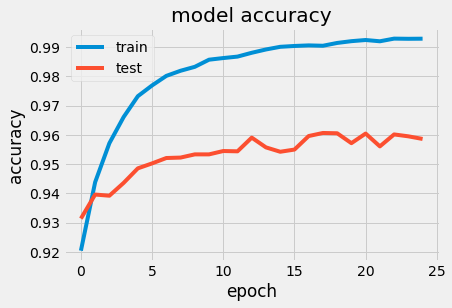

In [79]:

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

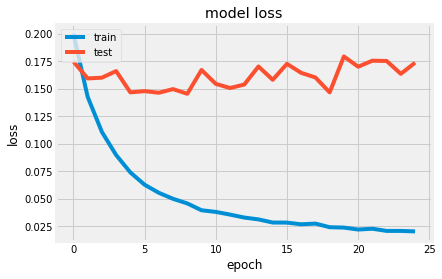

In [80]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [82]:
# evaluate model
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

prediction_probs = final_model.predict([X_1_test, X_2_test])
# predictions is list of definite [0,1] predictions as extracted from predicted probabilities
predictions = [np.array([1,0]) if x[0]>x[1] else np.array([0,1]) for x in prediction_probs]

# convert predictions and y_test back into regular list of 0s and 1s for sklearn functions
predictions_labels, y_test_labels = [], []
for i in range(len(y_test)):
    if predictions[i][1] == 1: 
        predictions_labels.append(1)
    else: 
        predictions_labels.append(0)
for i in range(len(y_test)):
    if y_test[i][1] == 1: 
        y_test_labels.append(1)
    else: 
        y_test_labels.append(0)

prfs = precision_recall_fscore_support(y_test_labels, predictions_labels, average='binary')
acc = accuracy_score(y_test_labels, predictions_labels)
print ("Accuracy:", acc)
print ("Precision:", round(prfs[0], 4))
print ("Recall:", round(prfs[1], 4))
print ("F1 Score:", round(prfs[2], 4))

Accuracy: 0.9586258401792382
Precision: 0.9405
Recall: 0.9787
F1 Score: 0.9592


In [83]:
# save val_acc and val_loss for each model to plot later
# can then plot the three model val_acc and val_loss together to see how they behave

# for each model there is list that contains acc, val_acc, loss, val_loss 
# (these mean model train accuracy, model test accuracy, model train loss, and model test loss)

doc2vec_val = {"acc": history.history["acc"], 
               "val_acc": history.history["val_acc"], 
               "loss": history.history["loss"], 
               "val_loss": history.history["val_loss"], 
               "accuracy": acc, 
               "precision": round(prfs[0], 4), 
               "recall": round(prfs[1], 4), 
               "F1": round(prfs[2], 4)}

In [84]:
doc2vec_words_val = {"acc": history.history["acc"], 
               "val_acc": history.history["val_acc"], 
               "loss": history.history["loss"], 
               "val_loss": history.history["val_loss"], 
               "accuracy": acc, 
               "precision": round(prfs[0], 4), 
               "recall": round(prfs[1], 4), 
               "F1": round(prfs[2], 4)}

In [85]:
word2vec_val = {"acc": history.history["acc"], 
               "val_acc": history.history["val_acc"], 
               "loss": history.history["loss"], 
               "val_loss": history.history["val_loss"], 
               "accuracy": acc, 
               "precision": round(prfs[0], 4), 
               "recall": round(prfs[1], 4), 
               "F1": round(prfs[2], 4)}

In [86]:
Google_word2vec_val = {"acc": history.history["acc"], 
                       "val_acc": history.history["val_acc"], 
                       "loss": history.history["loss"], 
                       "val_loss": history.history["val_loss"], 
                       "accuracy": acc, 
                       "precision": round(prfs[0], 4), 
                       "recall": round(prfs[1], 4), 
                       "F1": round(prfs[2], 4)}

In [93]:
# name of current model and model evaluation dictionary to use 
model_tag = "doc2vec_words"
current_val_dict = doc2vec_words_val

In [94]:
csv_file_name = model_tag + "_acc_loss.csv"
text_file_name = model_tag + "_acc_precision_recall.txt"

model_dataframe = pd.DataFrame({"acc": history.history["acc"], 
               "val_acc": history.history["val_acc"], 
               "loss": history.history["loss"], 
               "val_loss": history.history["val_loss"]})

model_dataframe.to_csv(csv_file_name, index=False)

with open(text_file_name, "w") as text_file:
    text_file.write("Accuracy: {}\n".format(current_val_dict["accuracy"]))
    text_file.write("Precision: {}\n".format(current_val_dict["precision"]))
    text_file.write("Recall: {}\n".format(current_val_dict["recall"]))
    text_file.write("F1: {}".format(current_val_dict["F1"]))

In [96]:
csv_file_name

'doc2vec_words_acc_loss.csv'

In [97]:
#doc2vec_df =  pd.read_csv("doc2vec_acc_loss.csv")
doc2vec_words_df = pd.read_csv("doc2vec_words_acc_loss.csv")
#word2vec_skipgram_df = pd.read_csv("question_vector_model_evaluation/word2vec_skipgram/word2vec_skipgram_acc_loss.csv")
#google_news_word2vec_df = pd.read_csv("question_vector_model_evaluation/google_news_word2vec/google_news_word2vec_acc_loss.csv")

In [99]:
doc2vec_words_df.head()

,acc,loss,val_acc,val_loss
0,0.920400,0.200232,0.931392,0.174983
1,0.943838,0.142836,0.939607,0.159541
2,0.957169,0.110867,0.939208,0.160218
3,0.966119,0.089807,0.943590,0.166232
4,0.973251,0.073977,0.948569,0.146848


In [100]:
plt.figure(figsize=(30,15))
plt.plot(doc2vec_df["val_acc"].values)
plt.plot(doc2vec_words_df["val_acc"].values)
plt.plot(word2vec_skipgram_df["val_acc"].values)
plt.plot(google_news_word2vec_df["val_acc"].values)
plt.title('Model Validation Accuracy', fontsize=50)
plt.ylabel('validattion accuracy', fontsize=40)
plt.xlabel('training epoch', fontsize=40)
plt.legend(['doc2vec', 'doc2vec_words', 'word2vec_skipgram', 'google_news'], loc='upper left', prop={'size':30})
plt.tick_params(labelsize=35)
plt.savefig('val_acc.png')

NameError: name 'doc2vec_df' is not defined

<Figure size 2160x1080 with 0 Axes>

In [ ]:

plt.figure(figsize=(30,15))
plt.plot(doc2vec_df["val_loss"].values)
plt.plot(doc2vec_words_df["val_loss"].values)
plt.plot(word2vec_skipgram_df["val_loss"].values)
plt.plot(google_news_word2vec_df["val_loss"].values)
plt.title('Model Validation Loss', fontsize=50)
plt.ylabel('validated loss', fontsize=40)
plt.xlabel('epoch', fontsize=40)
plt.legend(['doc2vec', 'doc2vec_words', 'word2vec_skipgram', 'google_news'], loc='upper left', prop={'size':30})
plt.tick_params(labelsize=35)
plt.savefig('val_loss.png')